In [1]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
from modules import local_eb_kernel as rk
from scipy.integrate import quad
import os
import timeit

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
#!mkdir $figpath
respath="../../figures/simulated/"
figpath=respath
datapath=respath + "generated_data/"
genplots=True
nomask=True

In [81]:
nside=8 ; upnside=nside ; npix=h.nside2npix(upnside)
lmax=3*nside ; lmin=2
ell=arange(lmax+1)
fll=ell*(ell+1)/(2.*pi)

odisc=min(180.,180.*(24./lmax))
print odisc

180.0


In [82]:
from matplotlib import rcParams,rc
params = {'backend': 'pdf',
          'savefig.dpi': 200,
          'axes.labelsize': 15,
          'text.fontsize': 15,
          'axes.linewidth' : 2,
          'lines.linewidth' : 2,
          'font.size': 15,
          'xtick.labelsize': 15,
          'ytick.major.pad': 6,
          'xtick.major.pad': 6,
          'ytick.labelsize': 15,
          'text.usetex': True,
          'font.family':'sans-serif',
          'font.sans-serif':'FreeSans',
          'image.cmap':'jet'}
rc('text.latex', preamble='\usepackage{sfmath}')
rcParams.update(params)

In [83]:
cltemp=h.read_cl("../../data/planck_wp_highL_lensing_param.fits")
cl=[cltemp[0],cltemp[1],cltemp[2],cltemp[3]*0] # Reverse E and B spectra

#cl=[cltemp[0],cltemp[2],cltemp[1],cltemp[3]*0] # Reverse E and B spectra
#figpath="../article/figures/complementary/"

random.seed(0) ; tqu=h.synfast(cl,nside,pol=True,new=True,verbose=False,lmax=3*nside-1,mmax=3*nside-1)

# Get teb maps from Healpix.
alm=h.map2alm(tqu,lmax=3*nside,pol=True) ; teb=h.alm2map(alm,upnside,pol=False,verbose=False)

# Get data power spectrum.
cld=h.alm2cl(alm)

# Get Q/U corresponding to E and B modes.
alm[2][:]=0.0 ; equ=h.alm2map(alm,nside=nside,pol=True,verbose=False)
alm=h.map2alm(tqu,lmax=3*nside,pol=True) ; alm[1][:]=0.0 ; bqu=h.alm2map(alm,nside=nside,pol=True,verbose=False)

fl=ones(3*nside+1,float) ; fl[:lmin+1]=0

In [84]:
h.write_map(datapath + "teb.fits",teb,overwrite=True)

In [85]:
y=rk.real_space_queb_kernels(nside,tmax=2.2*odisc,maxlmax=3*nside,sampling=2500)
y.calc_qu2eb_rad_kernel(lmax,lmin)
y.calc_qu2queb_rad_kernel(lmax,lmin)

In [88]:
y.setup_taper(1.*odisc,0.001) ; y.setup_fn_rad_ker()

<IPython.core.display.Javascript object>


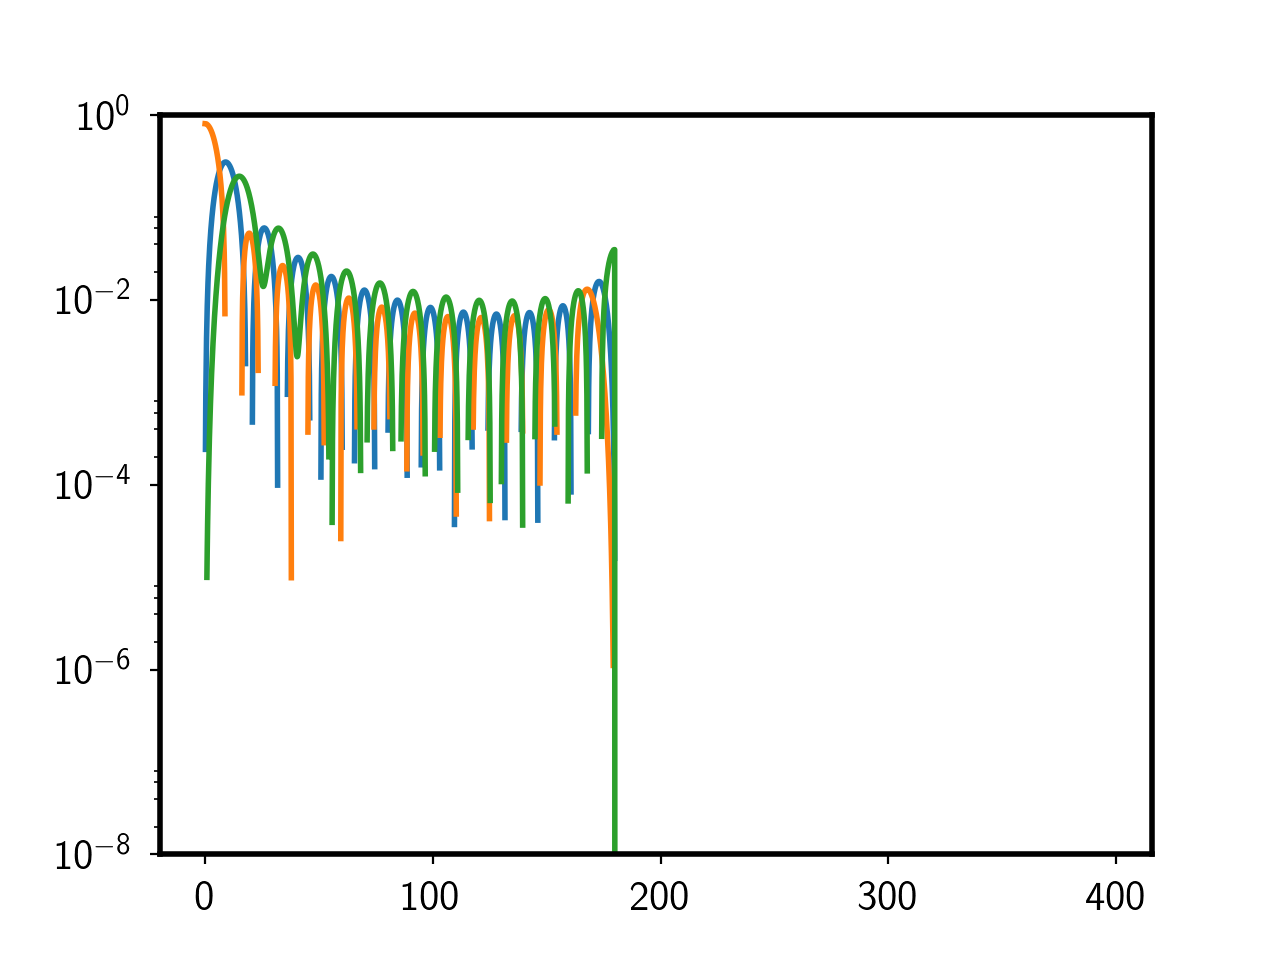

(1e-08, 1.0)

In [89]:
figure()
plot(y.theta*180/pi,y.fn_rad_ker(y.theta))
plot(y.theta*180/pi,y.fn_rad_ker_m2(y.theta))
plot(y.theta*180/pi,y.fn_rad_ker_p2(y.theta))
semilogy()
ylim(1e-8,1e0)

In [64]:
filenames=[]
filenames=append(filenames,datapath + "rteb_2beta.fits")
filenames=append(filenames,datapath + "rteb_1beta.fits")
filenames=append(filenames,datapath + "rteb_0p5beta.fits")
filenames=append(filenames,datapath + "rteb_0p25beta.fits")


fexist=True
for f in filenames:
    fexist=fexist and os.path.isfile(f)
fexist=False

In [65]:
if not(fexist):
    disc=2.*odisc ; y.setup_taper(disc,0.5*disc) ; y.setup_fn_rad_ker()
    rteb0=y.convert_qu2eb(tqu,discsize=disc)

    disc=1.0*odisc ; y.setup_taper(disc,0.5*disc) ; y.setup_fn_rad_ker()
    rteb1=y.convert_qu2eb(tqu,discsize=disc)

    disc=0.5*odisc ; y.setup_taper(disc,0.5*disc) ; y.setup_fn_rad_ker()
    rteb2=y.convert_qu2eb(tqu,discsize=disc)

    disc=0.25*odisc ; y.setup_taper(disc,0.5*disc) ; y.setup_fn_rad_ker()
    rteb3=y.convert_qu2eb(tqu,discsize=disc)

    h.write_map(datapath + "rteb_2beta.fits",rteb0,overwrite=True)
    h.write_map(datapath + "rteb_1beta.fits",rteb1,overwrite=True)
    h.write_map(datapath + "rteb_0p5beta.fits",rteb2,overwrite=True)
    h.write_map(datapath + "rteb_0p25beta.fits",rteb3,overwrite=True)
else:
    h.read_map(datapath + "rteb_2beta.fits",(0,1,2))
    h.read_map(datapath + "rteb_1beta.fits",(0,1,2))
    h.read_map(datapath + "rteb_0p5beta.fits",(0,1,2))
    h.read_map(datapath + "rteb_0p25beta.fits",(0,1,2))

<IPython.core.display.Javascript object>


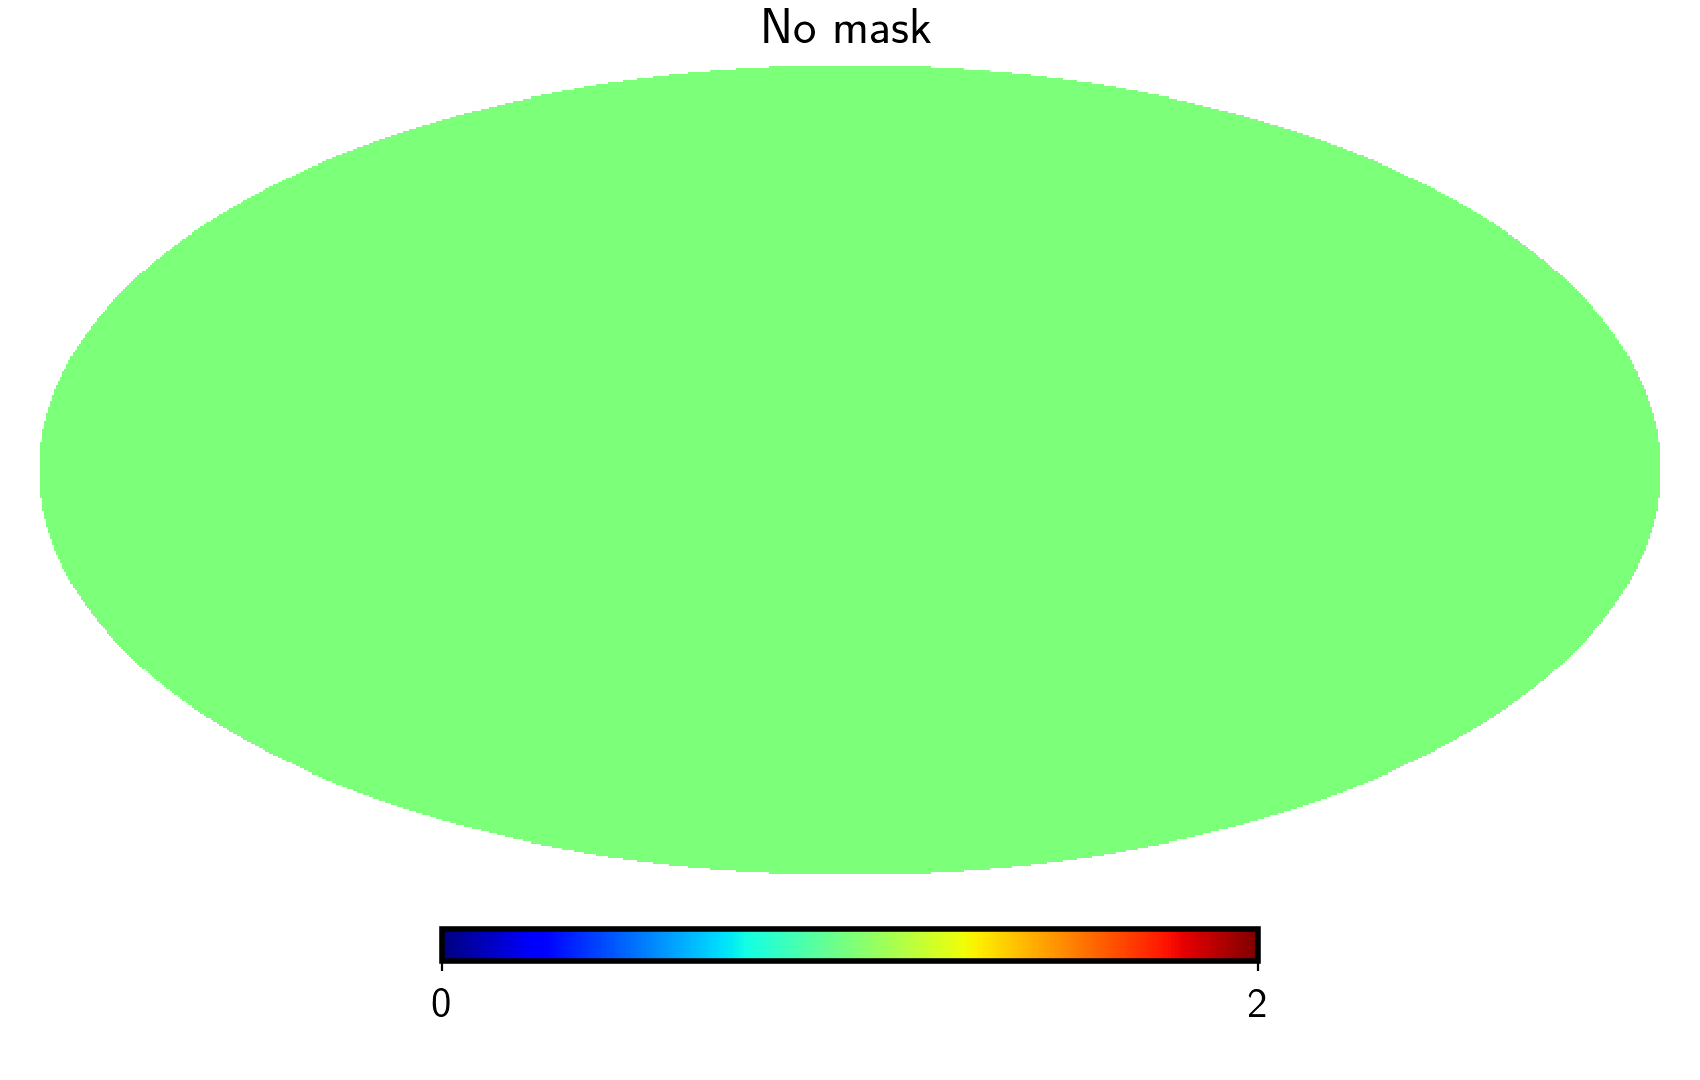

In [66]:
pindex=arange(npix) ; theta=h.pix2ang(nside,pindex)[0]*180/pi
mask=zeros(npix,float)
wband=60
capmask=zeros(npix,float) ; capmask[theta<wband]=1. ; capmask[theta>180-wband]=1.

capmaskon=False ; eqmaskon=False
nomask=True

if capmaskon:
    eqmaskon=False ; nomaskon=False
    mask[:]=capmask[:]
    figpath= respath + "capmask/" 
    !mkdir $figpath
    h.mollview(mask,title=r"Cap mask $(" + str(wband) + "^\circ)$")
    savefig(figpath + "capmask.pdf",dpi=300,bbox_inches="tight") 
    
if eqmaskon:
    nomask=False
    mask[:]=1- capmask[:]
    figpath=respath + "eqmask/" 
    !mkdir $figpath
    h.mollview(mask,title=r"Equatorial mask $(" + str(wband) + "^\circ)$")
    savefig(figpath + "eqmask.pdf",dpi=300,bbox_inches="tight") 
    
if nomask:
    mask[:]=1. 
    figpath=respath
    h.mollview(mask,title="No mask")
    savefig(figpath + "nomask.pdf",dpi=300,bbox_inches="tight") 


In [67]:
#clrteb4=h.alm2cl(h.map2alm(rteb4,pol=False,lmax=3*nside))
cld=h.alm2cl(h.map2alm(teb*mask,pol=False,lmax=lmax))
clrteb0=h.alm2cl(h.map2alm(rteb0*mask,pol=False,lmax=lmax))
clrteb1=h.alm2cl(h.map2alm(rteb1*mask,pol=False,lmax=lmax))
clrteb2=h.alm2cl(h.map2alm(rteb2*mask,pol=False,lmax=lmax))
clrteb3=h.alm2cl(h.map2alm(rteb3*mask,pol=False,lmax=lmax))

<IPython.core.display.Javascript object>


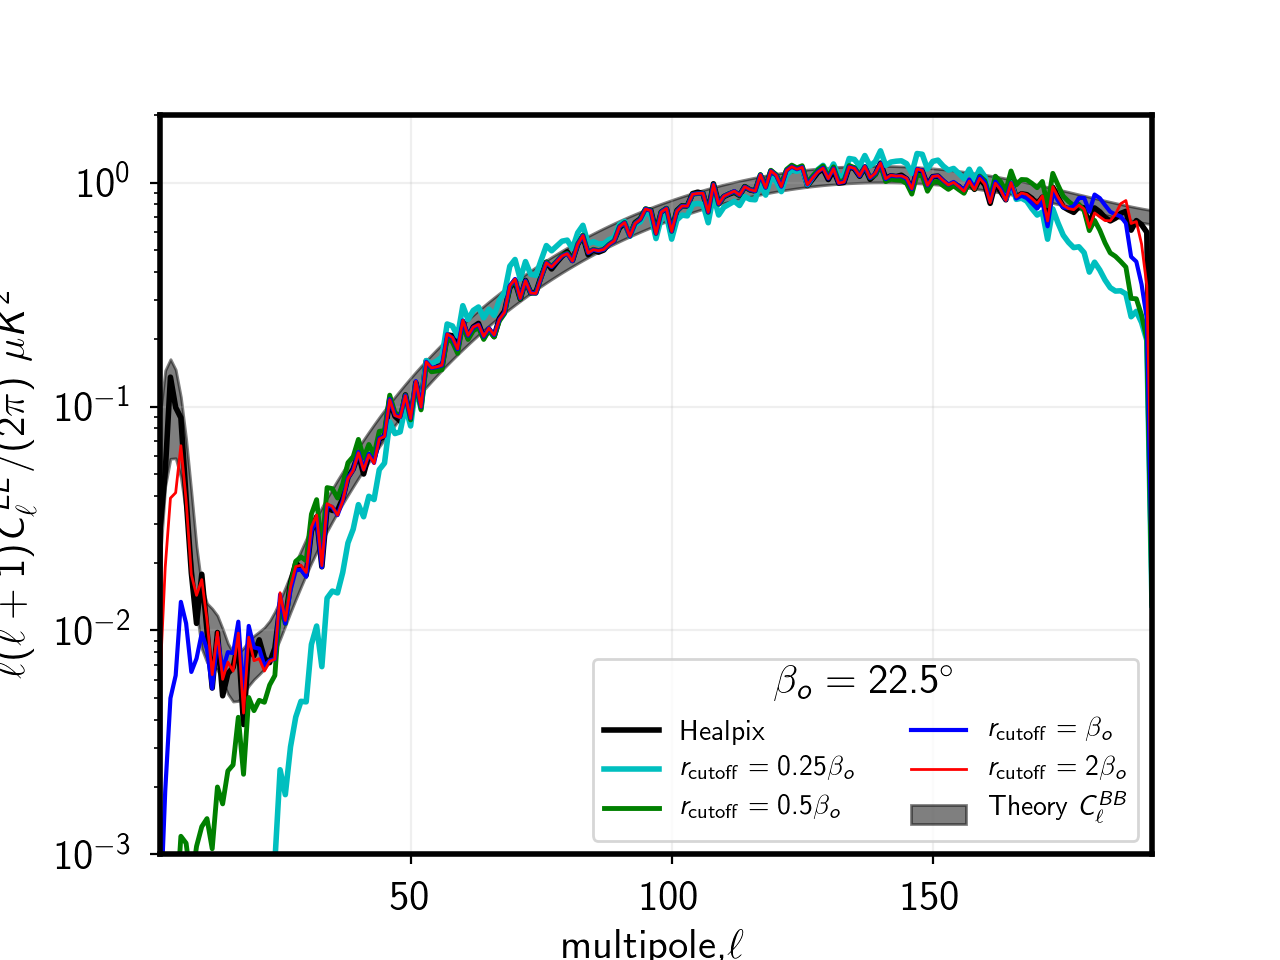

In [68]:
figure()
#plot(ell,fll*cl[1][:lmax+1],"k-",lw=5,label=r"Theory",alpha=0.4)
std=sqrt(2./(2.*ell+1))*cl[1][:lmax+1]
fill_between(ell,fll*(cl[1][:lmax+1]-std),fll*(cl[1][:lmax+1]+std),color="k",alpha=0.5,label=r"Theory $C^{BB}_{\ell}$")
plot(ell,fll*cld[1],"k-",label="Healpix")
plot(ell,fll*clrteb3[1],"c-",lw=2,label=r"$r_{\rm cutoff} = 0.25\beta_{o}$")
plot(ell,fll*clrteb2[1],"g-",lw=1.75,label=r"$r_{\rm cutoff} = 0.5\beta_{o}$")
plot(ell,fll*clrteb1[1],"b-",lw=1.5,label=r"$r_{\rm cutoff} = \beta_{o}$")
plot(ell,fll*clrteb0[1],"r-",lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
#plot(ell,fll*clrteb4[1],"m-",lw=2,label=r"$r_{\rm cutoff} = 4\beta_{o}$")
semilogy()
ylim(1e-3,2)
xlim(2,3*nside)
xlabel("multipole,$\ell$")
ylabel("$\ell(\ell+1)C^{EE}_{\ell}/(2\pi) ~ \mu K^2$")
legend(loc=0,fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
grid(alpha=0.2,linestyle="solid")
if genplots:
    savefig(figpath + "ee-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


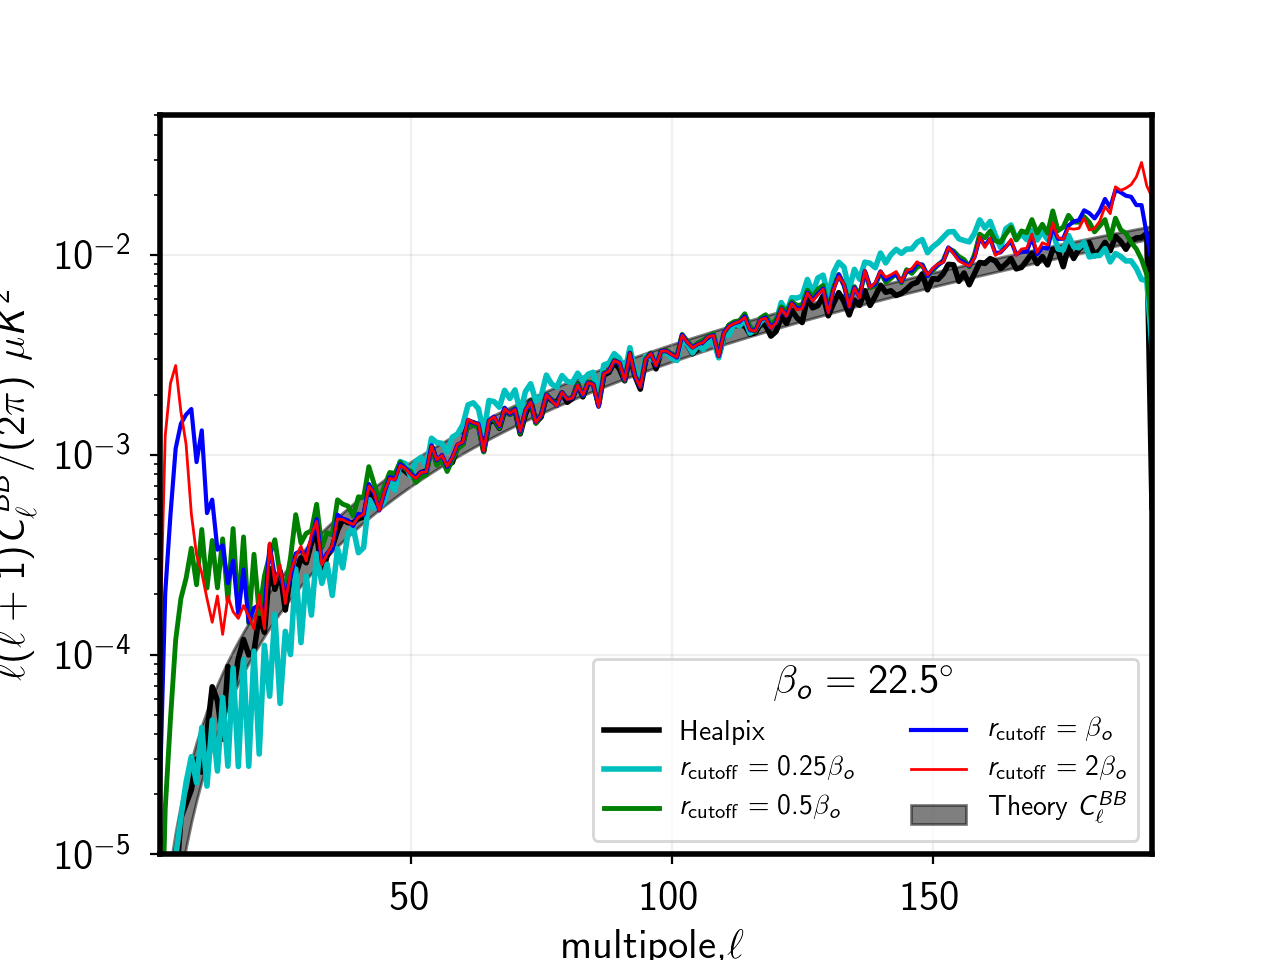

In [69]:
figure()
#plot(ell,fll*cl[2][:lmax+1],"k-",lw=6,label=r"Theory",alpha=0.2)
std=sqrt(2./(2.*ell+1))*cl[2][:lmax+1]
fill_between(ell,fll*(cl[2][:lmax+1]-std),fll*(cl[2][:lmax+1]+std),color="k",alpha=0.5,label=r"Theory $C^{BB}_{\ell}$")
plot(ell,fll*cld[2],"k-",label="Healpix")
plot(ell,fll*clrteb3[2],"c-",lw=2,label=r"$r_{\rm cutoff} = 0.25\beta_{o}$")
plot(ell,fll*clrteb2[2],"g-",lw=1.75,label=r"$r_{\rm cutoff} = 0.5\beta_{o}$")
plot(ell,fll*clrteb1[2],"b-",lw=1.5,label=r"$r_{\rm cutoff} = \beta_{o}$")
plot(ell,fll*clrteb0[2],"r-",lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
#plot(ell,fll*clrteb4[2],"m-",lw=2,label=r"$r_{\rm cutoff} = 4\beta_{o}$")
semilogy()
ylim(1e-5,5e-2)
xlim(2,3*nside)
xlabel("multipole,$\ell$")
ylabel("$\ell(\ell+1)C^{BB}_{\ell}/(2\pi) ~ \mu K^2$")
legend(loc="lower right",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
grid(alpha=0.2,linestyle="solid")
if genplots:
    savefig(figpath + "bb-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


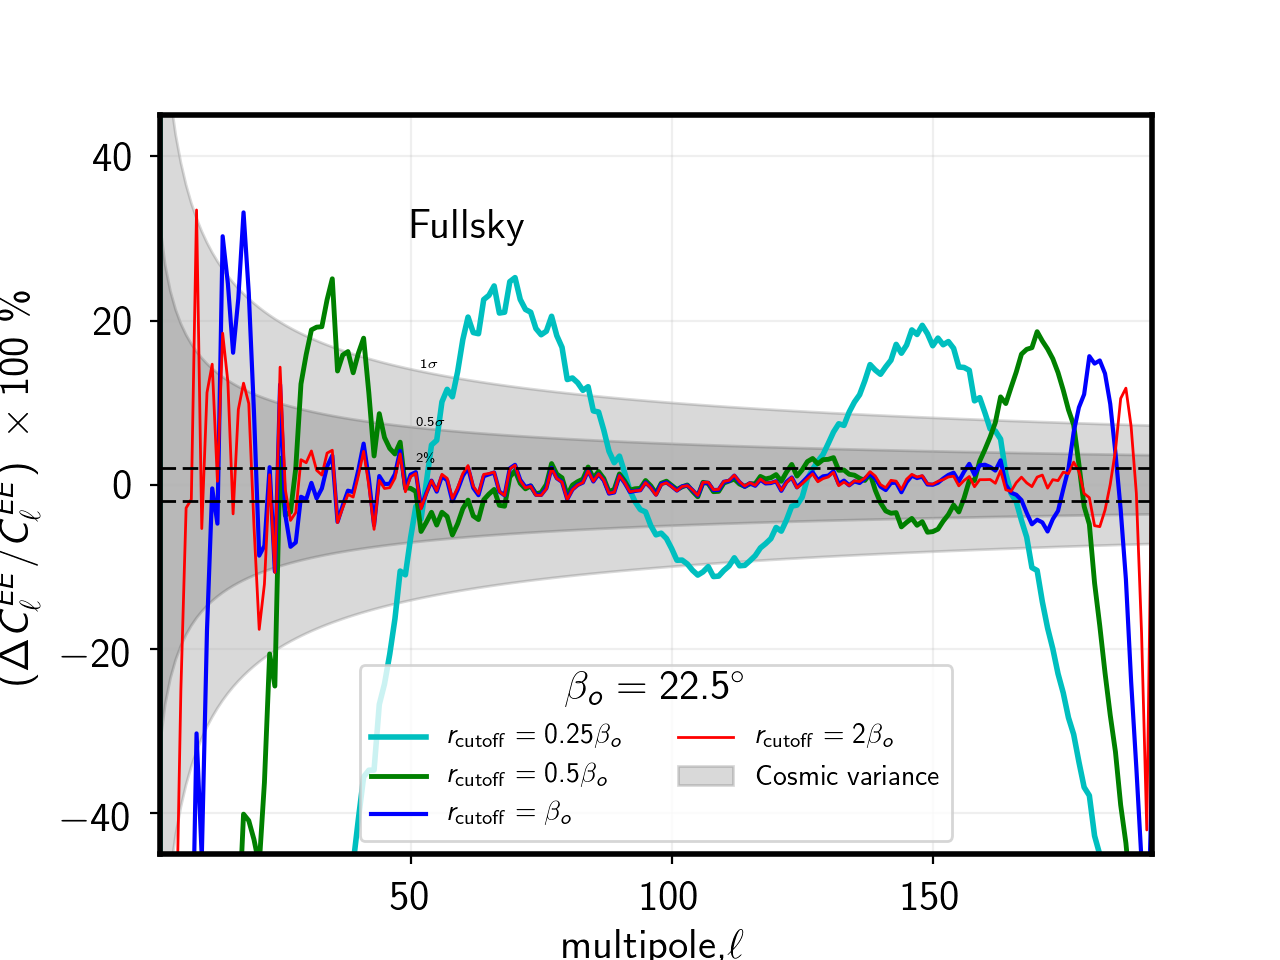

In [70]:
figure()
std=cld[1]/100.
plot(ell,(clrteb3[1]-cld[1])/std,"c-",lw=2,label=r"$r_{\rm cutoff} = 0.25\beta_{o}$")
plot(ell,(clrteb2[1]-cld[1])/std,"g-",lw=1.75,label=r"$r_{\rm cutoff} = 0.5\beta_{o}$")
plot(ell,(clrteb1[1]-cld[1])/std,"b-",lw=1.5,label=r"$r_{\rm cutoff} = \beta_{o}$")
plot(ell,(clrteb0[1]-cld[1])/std,"r-",lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
#plot(ell,(clrteb4[1]-cld[1])/std,"m-",lw=1,label=r"$r_{\rm cutoff} = 4\beta_{o}$")
fill_between(ell,-sqrt(2./(2.*ell+1))*100,sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="Cosmic variance")
fill_between(ell,-0.5*sqrt(2./(2.*ell+1))*100,0.5*sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="")
ylim(-45,45)
xlim(2,3*nside)
xlabel("multipole,$\ell$")
ylabel(r"$(\Delta C^{EE}_{\ell}/C^{EE}_{\ell}) ~\times 100 ~\%$")
legend(loc="lower center",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
axhline(-2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
grid(alpha=0.2,linestyle="solid")
text(52,14.2,r"$1 \sigma$",fontsize=5)
text(51,7.2,r"$0.5 \sigma$",fontsize=5)
text(51,2.8,r"$2 \%$",fontsize=5)

if nomask:
    text(50,30,"Fullsky")
elif eqmaskon:
    text(50,30,r"Masked $|b|>30^{\circ}$")
elif capmaskon:
    text(50,30,r"Masked $|b|<30^{\circ}$")
    
if genplots:
    savefig(figpath + "relative-percentage-err-ee-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


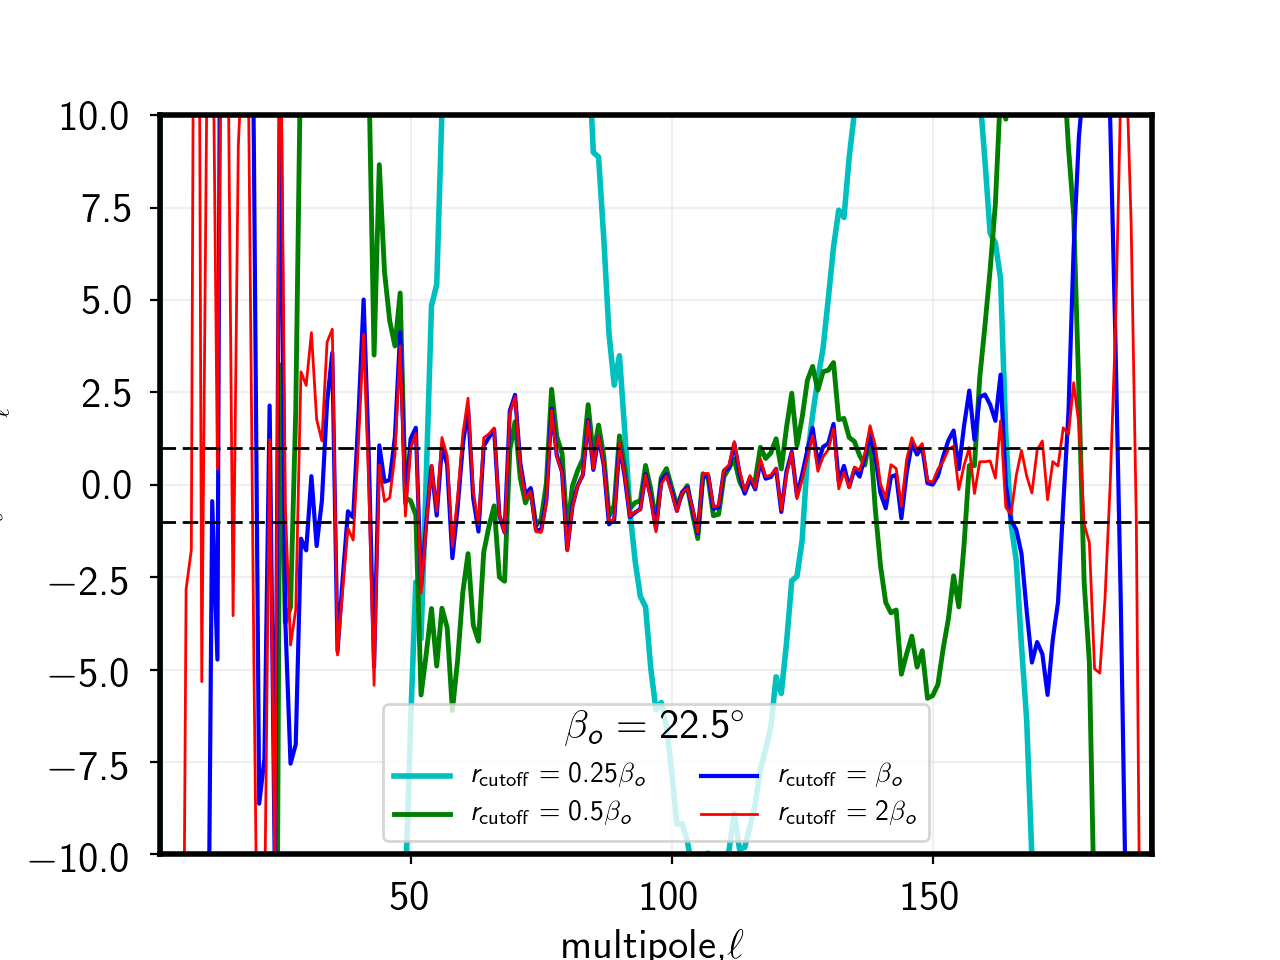

In [80]:
figure()
#std=sqrt(2./(2.*ell+1))*cld[1]
std=cld[1]/100.
plot(ell,(clrteb3[1]-cld[1])/std,"c-",lw=2,label=r"$r_{\rm cutoff} = 0.25\beta_{o}$")
plot(ell,(clrteb2[1]-cld[1])/std,"g-",lw=1.75,label=r"$r_{\rm cutoff} = 0.5\beta_{o}$")
plot(ell,(clrteb1[1]-cld[1])/std,"b-",lw=1.5,label=r"$r_{\rm cutoff} = \beta_{o}$")
plot(ell,(clrteb0[1]-cld[1])/std,"r-",lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
#plot(ell,(clrteb4[1]-cld[1])/std,"m-",lw=1,label=r"$r_{\rm cutoff} = 4\beta_{o}$")
ylim(-10,10)
xlim(2,3*nside)
axhline(-1.,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(1.,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
xlabel("multipole,$\ell$")
ylabel("$\Delta C^{EE}_{\ell}/\sigma_{C^{EE}_{\ell}}$")
legend(loc="lower center",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
grid(alpha=0.2,linestyle="solid")
if genplots:
    savefig(figpath + "diff-ee-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


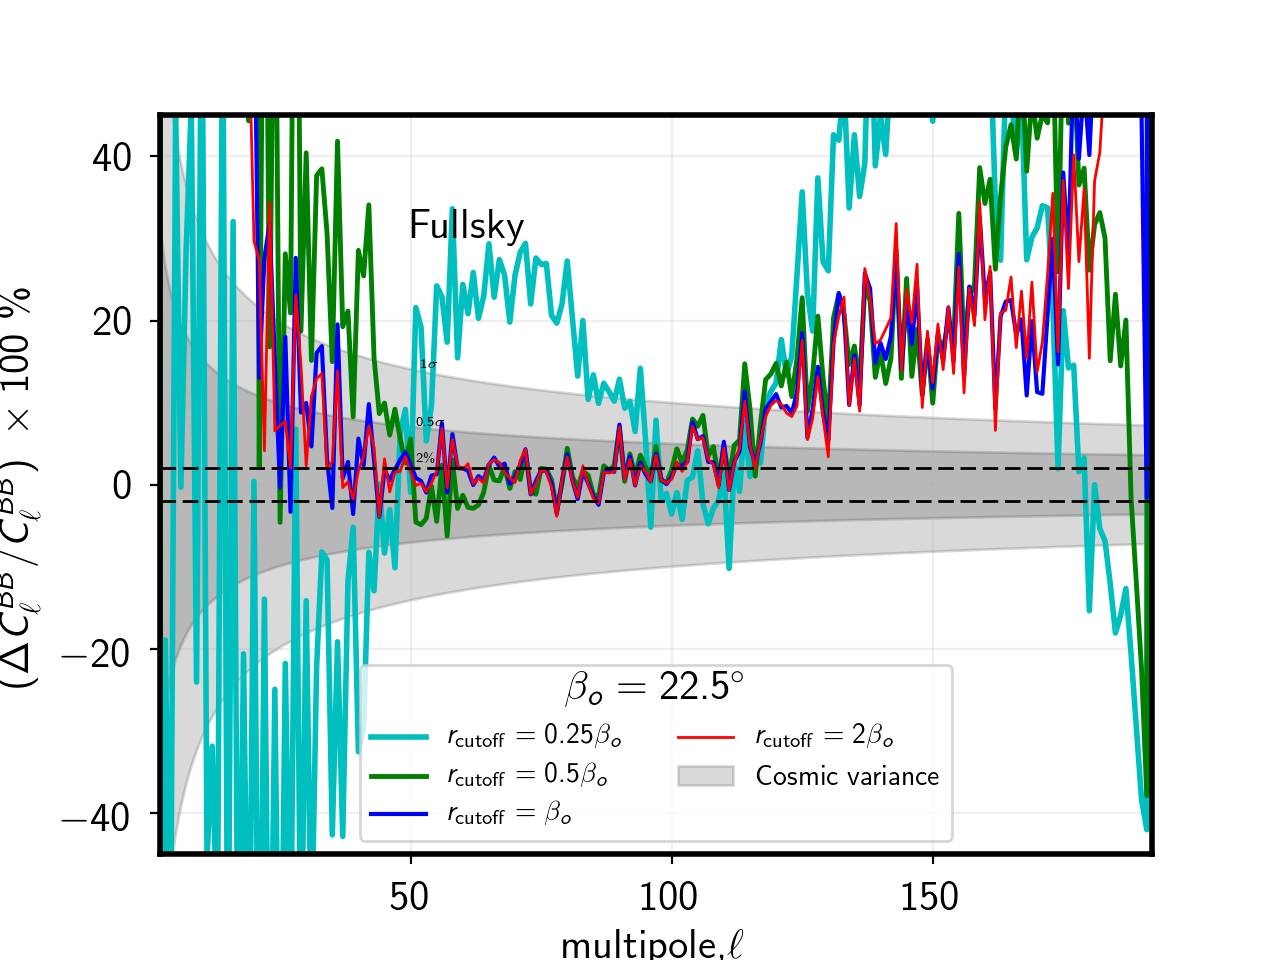

In [72]:
figure()
std=cld[2]/100.
plot(ell,(clrteb3[2]-cld[2])/std,"c-",lw=2,label=r"$r_{\rm cutoff} = 0.25\beta_{o}$")
plot(ell,(clrteb2[2]-cld[2])/std,"g-",lw=1.75,label=r"$r_{\rm cutoff} = 0.5\beta_{o}$")
plot(ell,(clrteb1[2]-cld[2])/std,"b-",lw=1.5,label=r"$r_{\rm cutoff} = \beta_{o}$")
plot(ell,(clrteb0[2]-cld[2])/std,"r-",lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
#plot(ell,(clrteb4[2]-cld[2])/std,"m-",lw=1,label=r"$r_{\rm cutoff} = 4\beta_{o}$")
fill_between(ell,-sqrt(2./(2.*ell+1))*100,sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="Cosmic variance")
fill_between(ell,-0.5*sqrt(2./(2.*ell+1))*100,0.5*sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="")
ylim(-45,45)
xlim(2,3*nside)
xlabel("multipole,$\ell$")
ylabel(r"$(\Delta C^{BB}_{\ell}/C^{BB}_{\ell}) ~\times 100 ~\%$")
legend(loc="lower center",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
axhline(-2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
grid(alpha=0.2,linestyle="solid")
text(52,14.2,r"$1 \sigma$",fontsize=5)
text(51,7.2,r"$0.5 \sigma$",fontsize=5)
text(51,2.8,r"$2 \%$",fontsize=5)
if nomask:
    text(50,30,"Fullsky")
elif eqmaskon:
    text(50,30,r"Masked $|b|>30^{\circ}$")
elif capmaskon:
    text(50,30,r"Masked $|b|<30^{\circ}$")
    
if genplots:
    savefig(figpath + "relative-percentage-err-bb-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


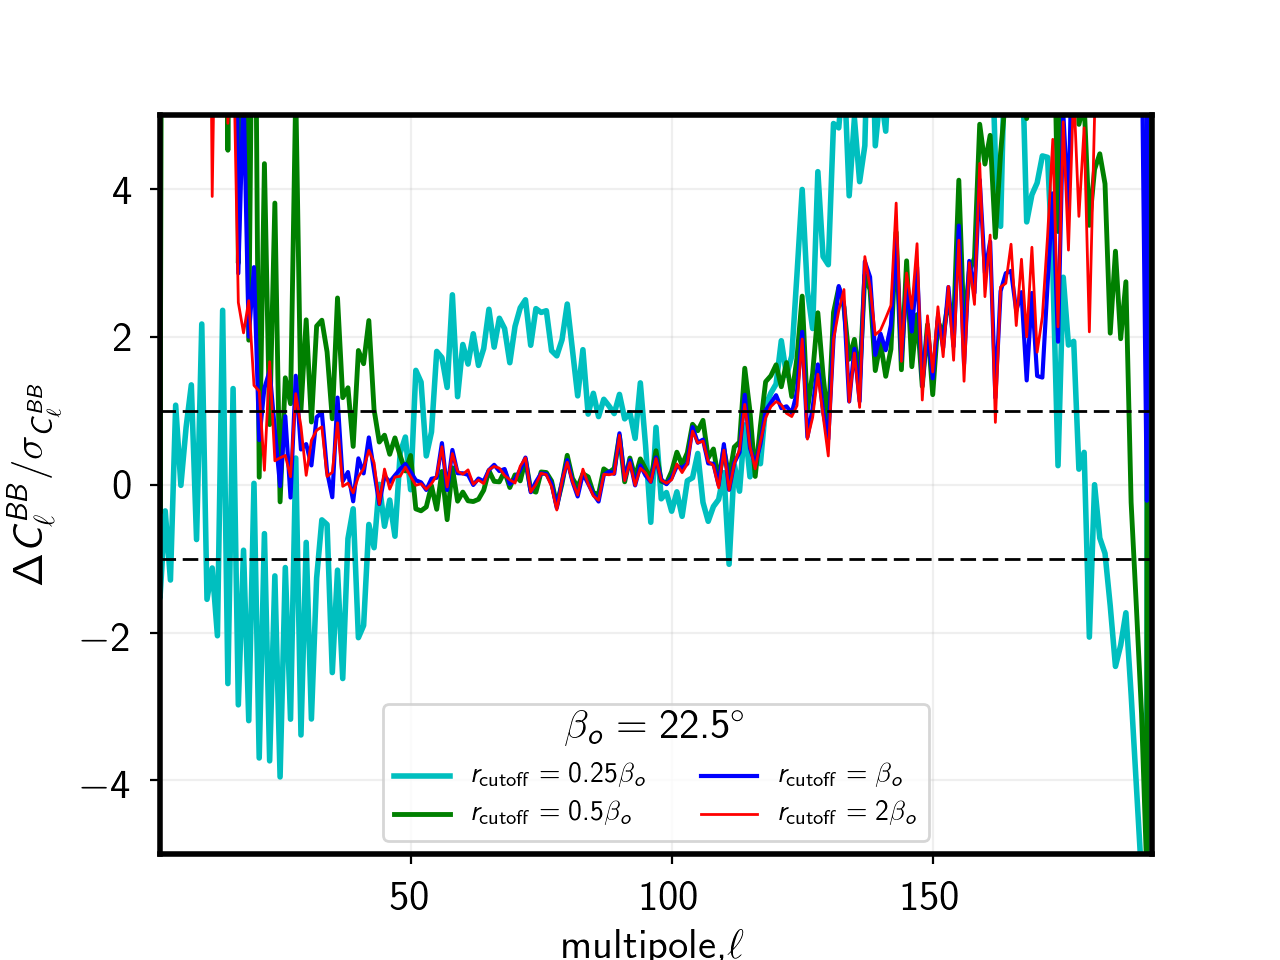

In [73]:
figure()
std=sqrt(2./(2.*ell+1))*cld[2]
plot(ell,(clrteb3[2]-cld[2])/std,"c-",lw=2,label=r"$r_{\rm cutoff} = 0.25\beta_{o}$")
plot(ell,(clrteb2[2]-cld[2])/std,"g-",lw=1.75,label=r"$r_{\rm cutoff} = 0.5\beta_{o}$")
plot(ell,(clrteb1[2]-cld[2])/std,"b-",lw=1.5,label=r"$r_{\rm cutoff} = \beta_{o}$")
plot(ell,(clrteb0[2]-cld[2])/std,"r-",lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
#plot(ell,(clrteb4[2]-cld[2])/std,"m-",lw=1,label=r"$r_{\rm cutoff} = 4\beta_{o}$")
ylim(-5,5)
xlim(2,3*nside)
axhline(-1,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(1,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
grid(alpha=0.2,linestyle="solid")
xlabel("multipole,$\ell$")
ylabel("$\Delta C^{BB}_{\ell}/\sigma_{C^{BB}_{\ell}}$")
legend(loc="lower center",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
if genplots:
    savefig(figpath + "diff-bb-spectrum-radial-cutoff.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


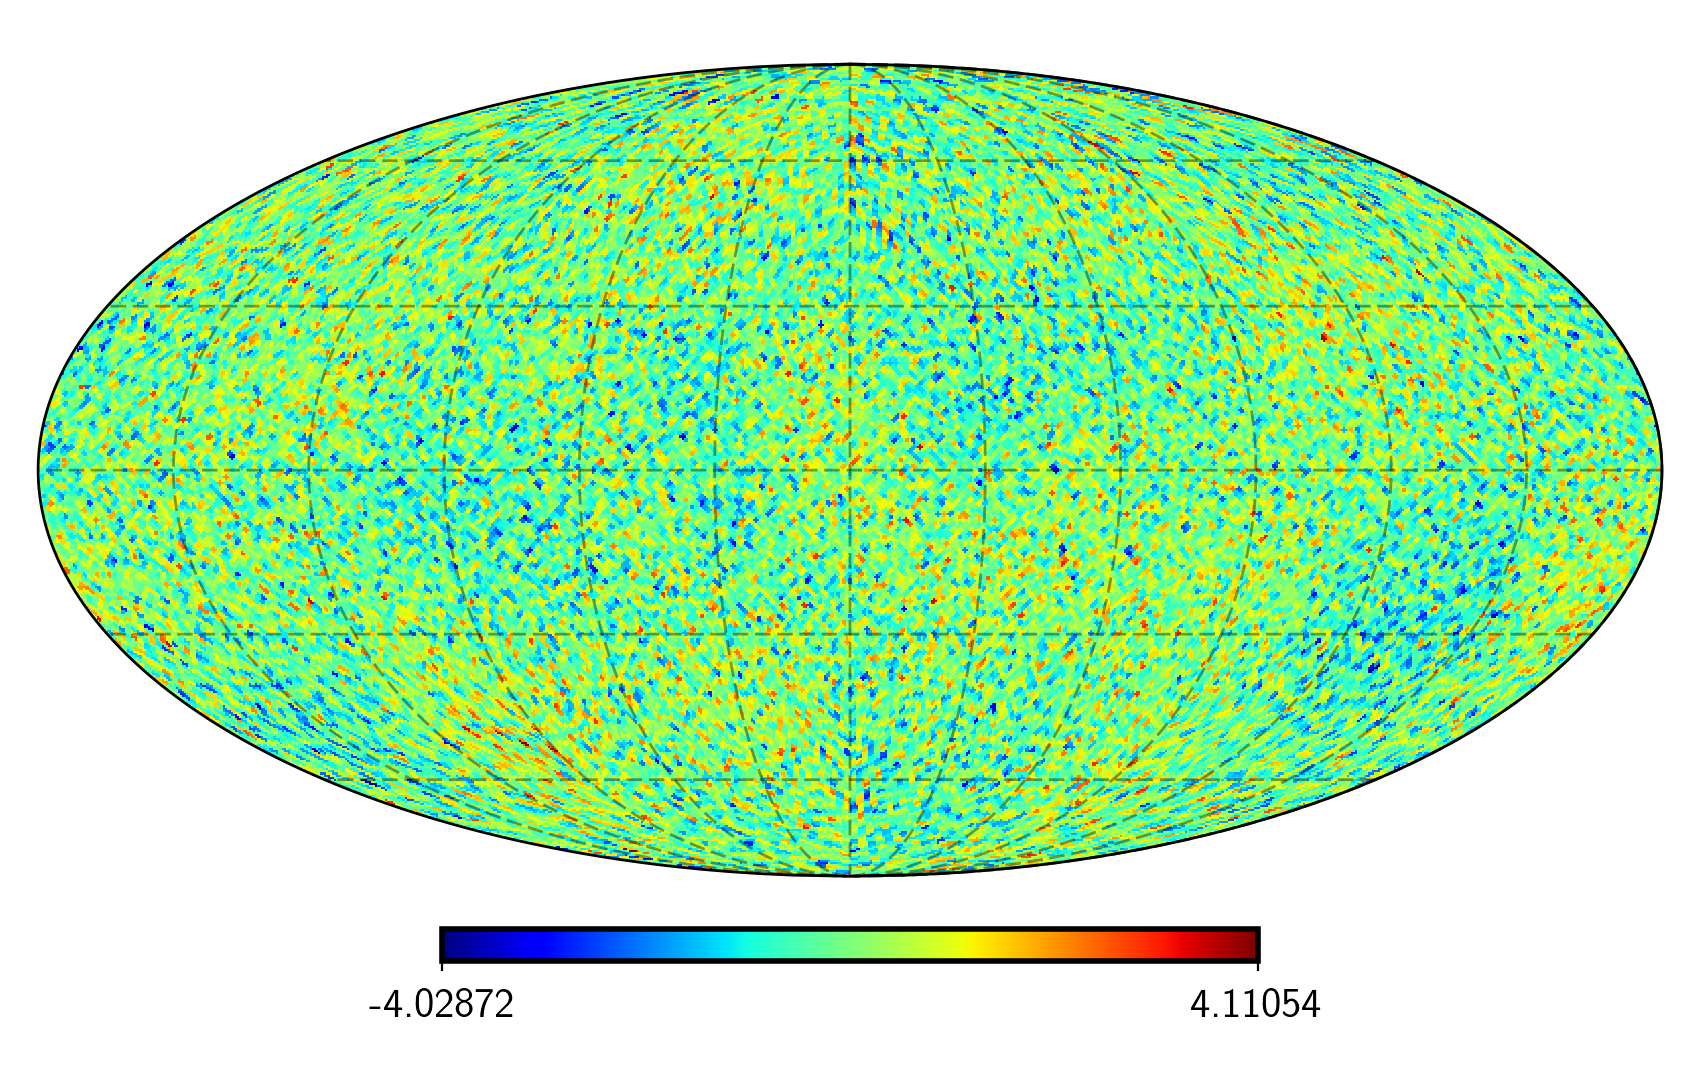

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


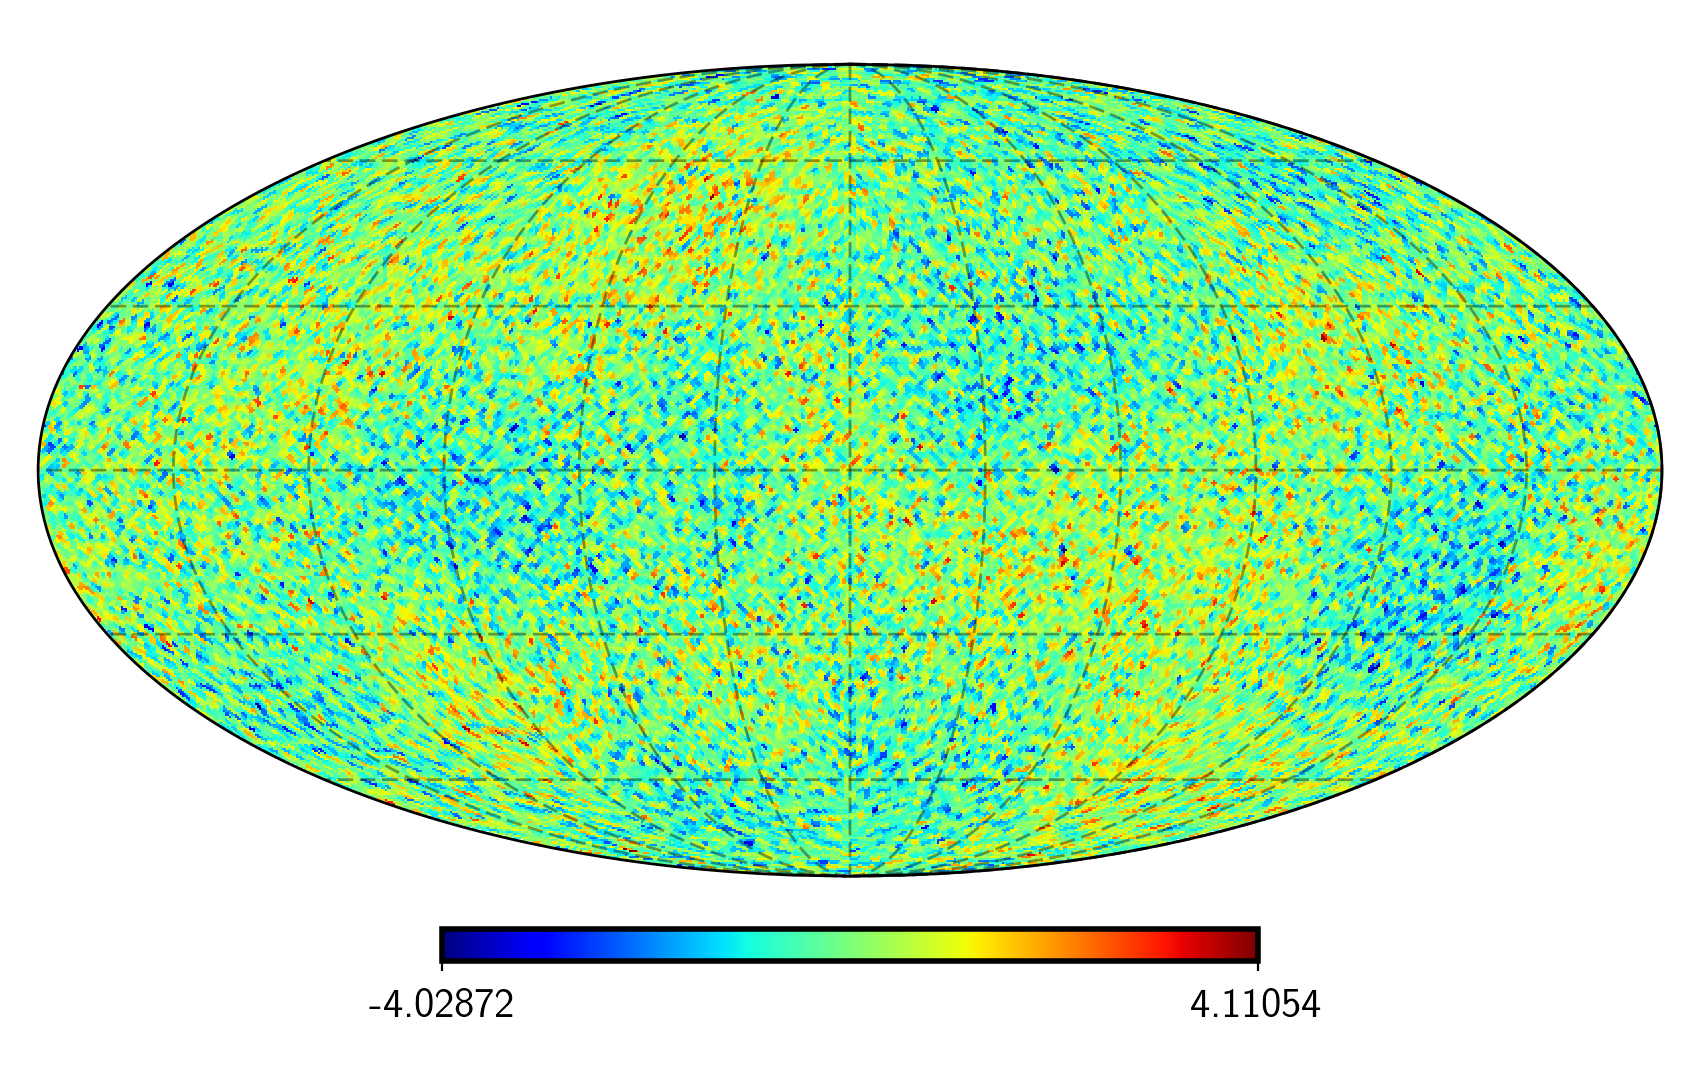

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


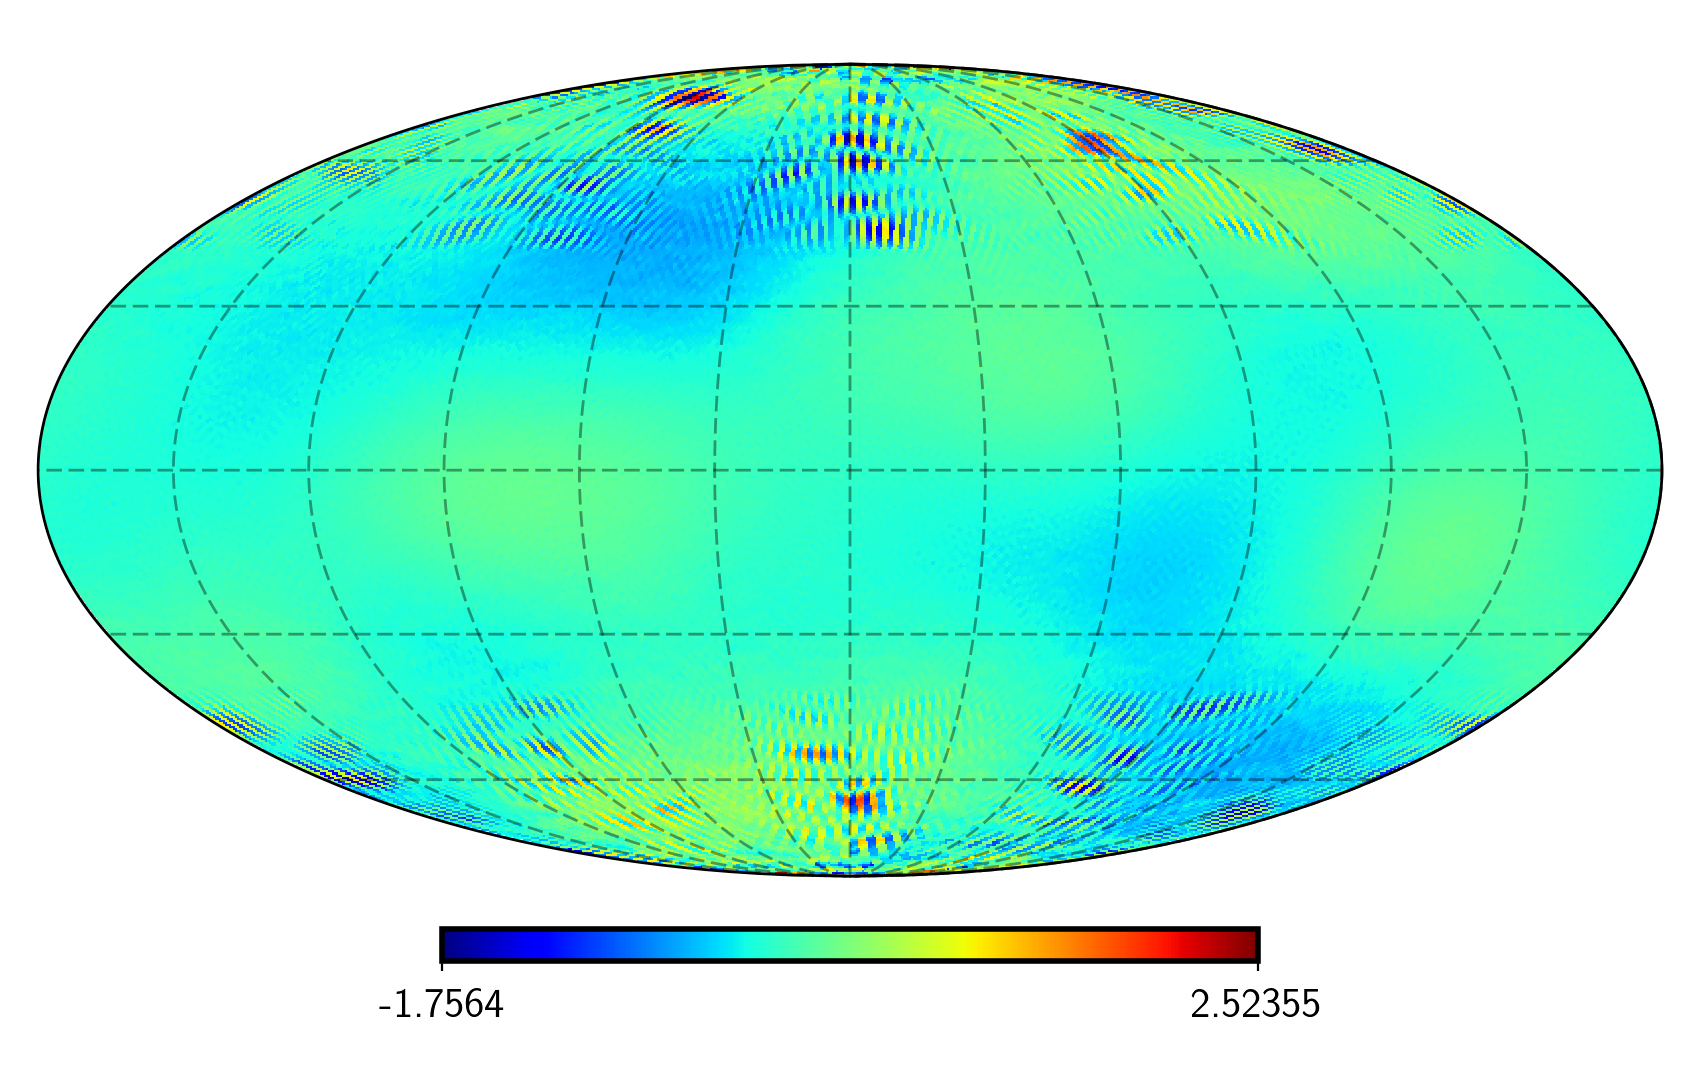

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [74]:
vmin=min(teb[1][mask!=0]) ; vmax=max(teb[1][mask!=0])

h.mollview(rteb0[1]*mask,min=vmin,max=vmax,title="") ; h.graticule(linestyle="dashed",alpha=0.4)
if genplots:
    savefig(figpath + "emap-2beta.pdf",dpi=300,bbox_inches="tight")
    
h.mollview(teb[1]*mask,min=vmin,max=vmax,title="") ; h.graticule(linestyle="dashed",alpha=0.4)
if genplots:
    savefig(figpath + "emap-healpix.pdf",dpi=300,bbox_inches="tight")
    
h.mollview((rteb0[1]-teb[1])*mask,title="") ; h.graticule(linestyle="dashed",alpha=0.4)
if genplots:
    savefig(figpath + "emap-diff.pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>


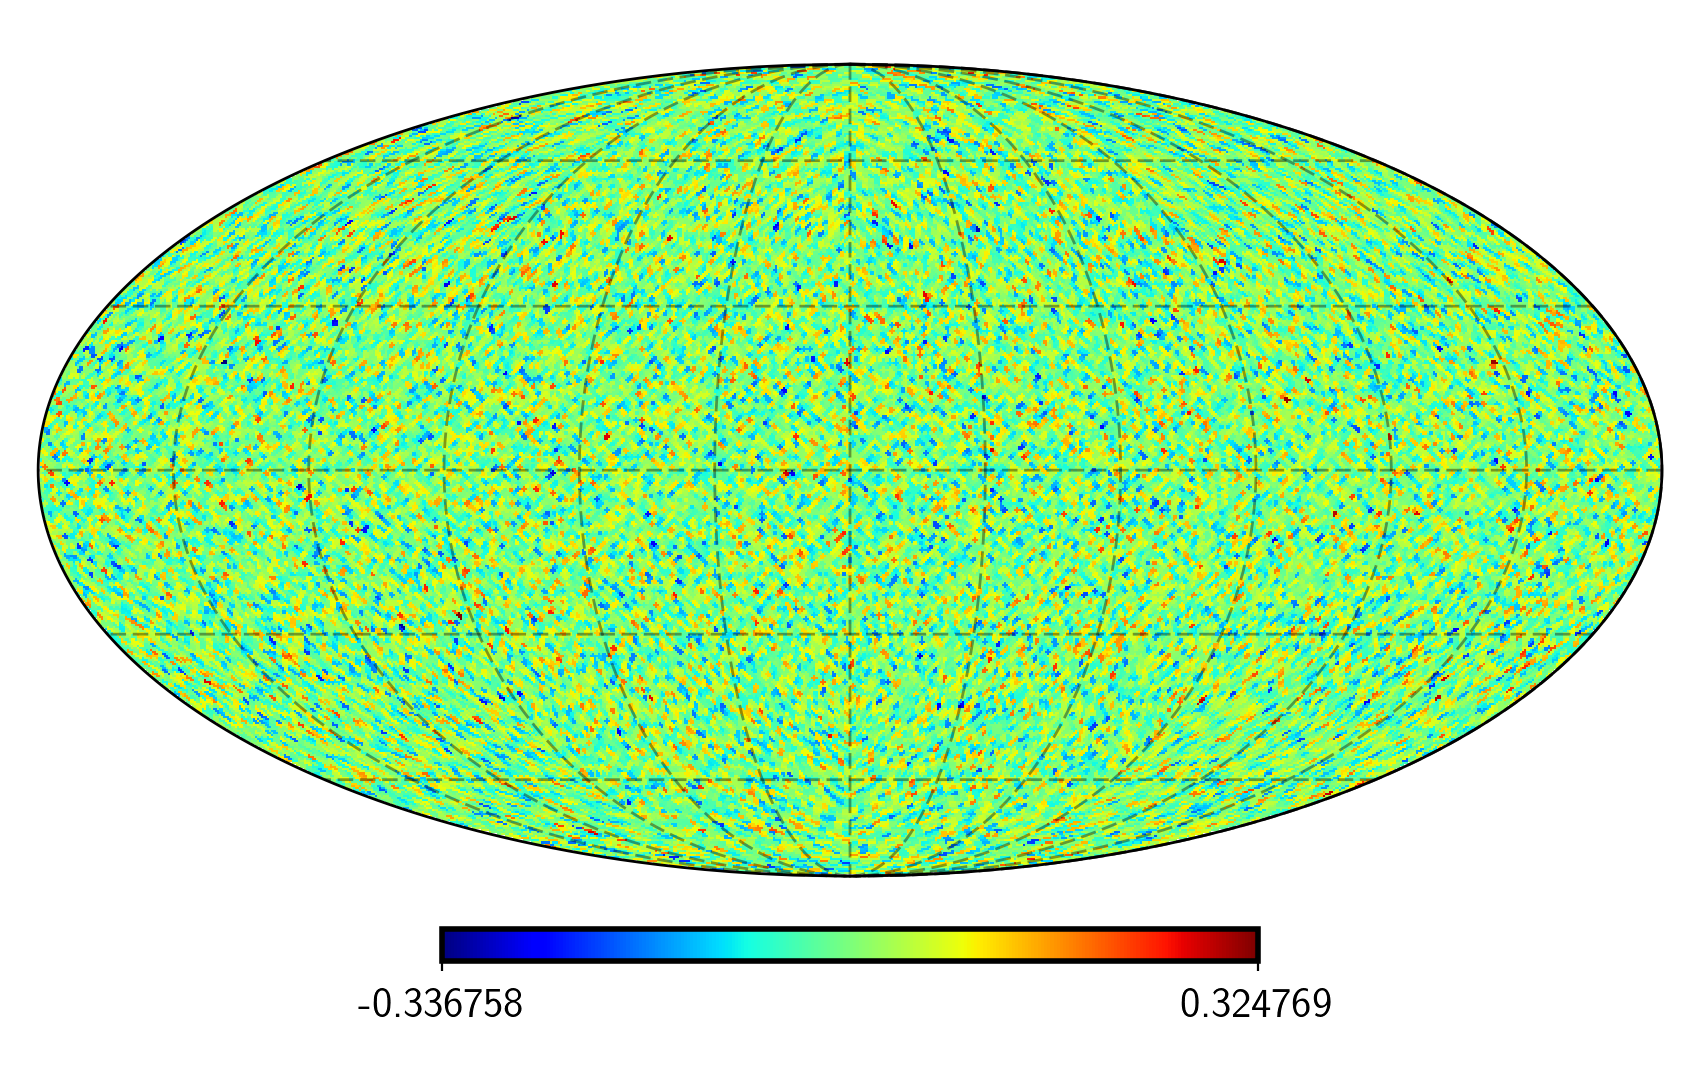

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


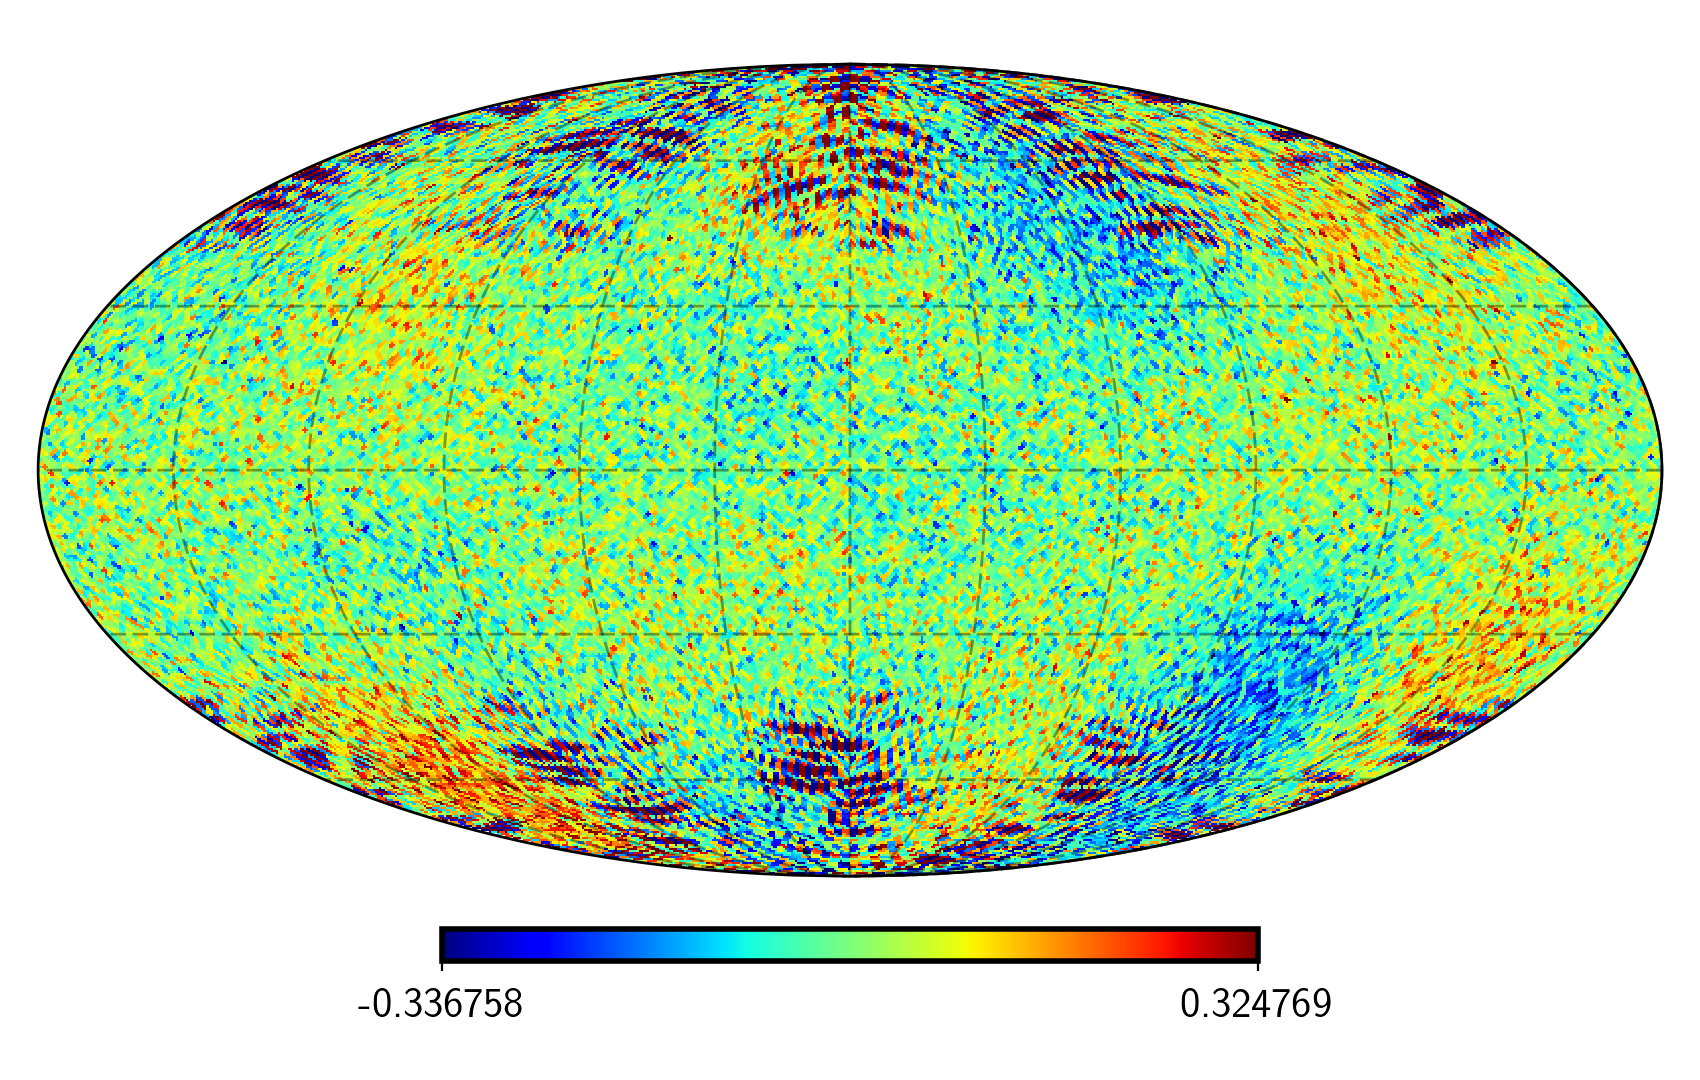

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<IPython.core.display.Javascript object>


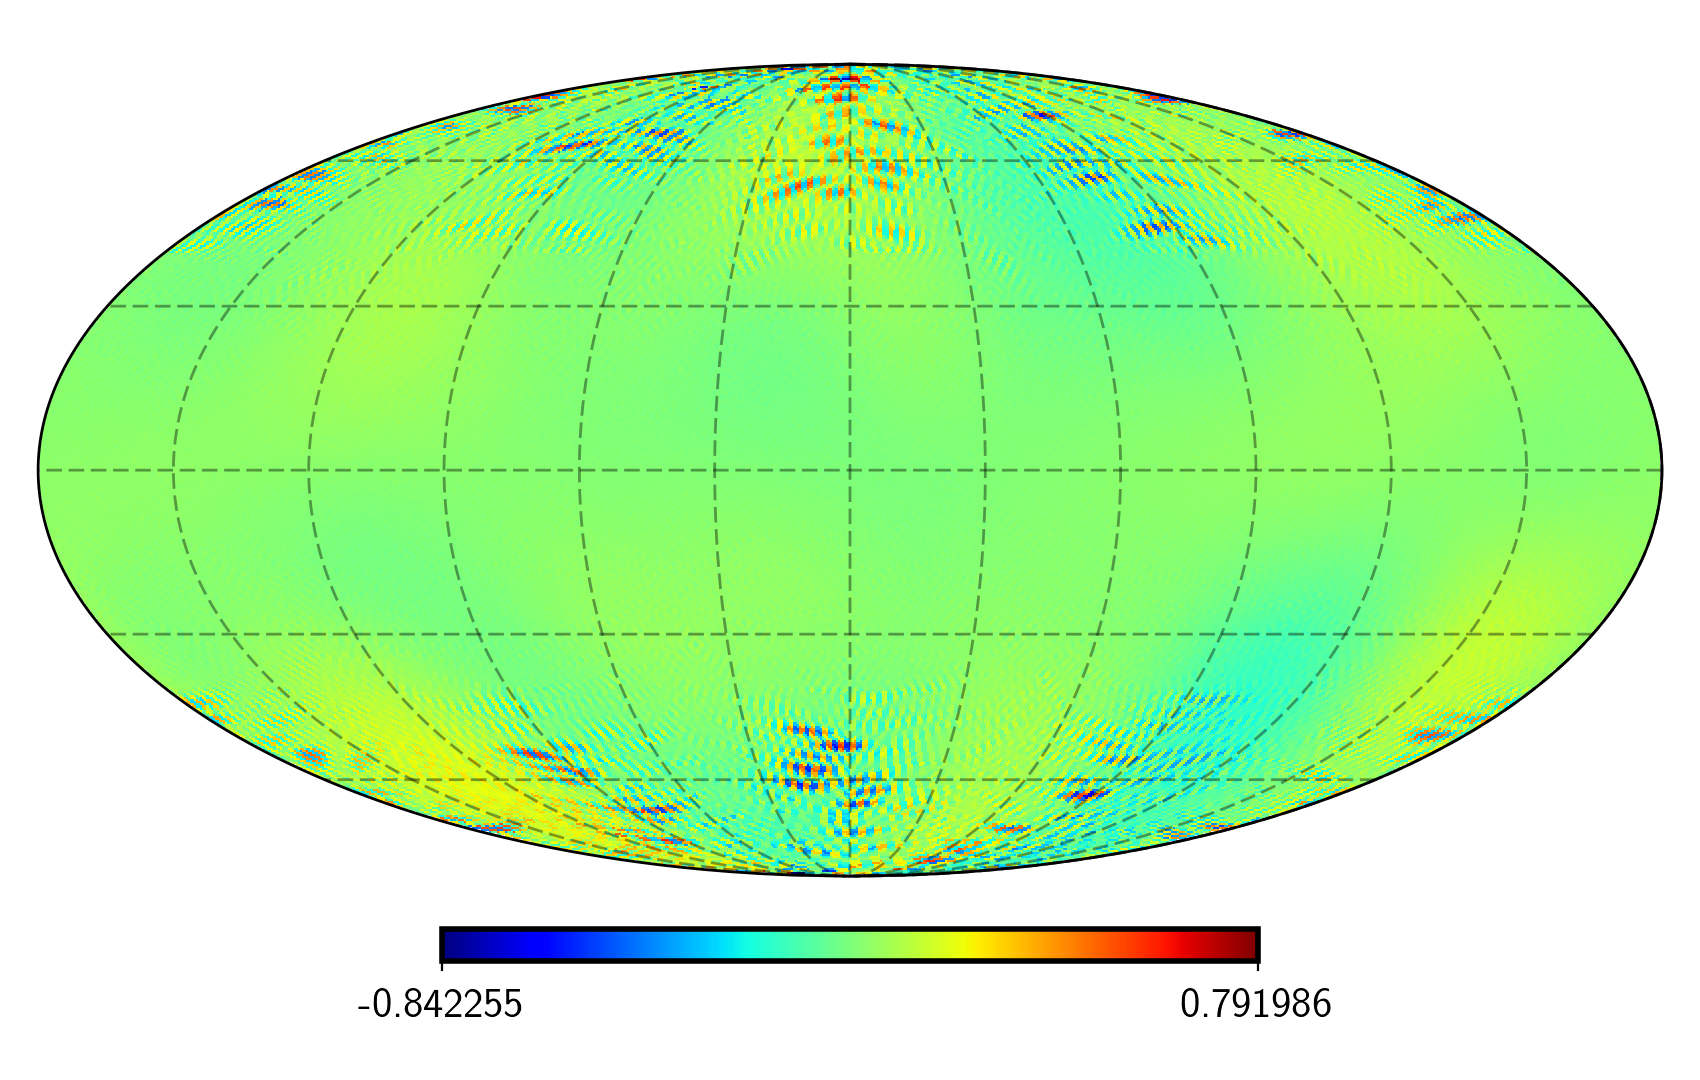

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [75]:
vmin=min(teb[2][mask!=0]) ; vmax=max(teb[2][mask!=0])
h.mollview(teb[2]*mask,min=vmin,max=vmax,title="") ; h.graticule(linestyle="dashed",alpha=0.4)
if genplots:
    savefig(figpath + "bmap-healpix.pdf",dpi=300,bbox_inches="tight")
    
h.mollview(rteb0[2]*mask,min=vmin,max=vmax,title="") ; h.graticule(linestyle="dashed",alpha=0.4)
if genplots:
    savefig(figpath + "bmap-2beta.pdf",dpi=300,bbox_inches="tight")
    
h.mollview((rteb0[2]-teb[2])*mask,title="") ; h.graticule(linestyle="dashed",alpha=0.4)
if genplots:
    savefig(figpath + "bmap-diff.pdf",dpi=300,bbox_inches="tight")